This Jupyter notebook contains the code used to produce the supplemental figures in the paper "Characterizing the Multisectoral Impacts of Future Global Hydrologic Variability" by Birnbaum et al. currently under review.

# Import Statements

Begin by importing the following relavent Python libraries/packages

In [1]:
#load in self-defined functions in stochastic_error_model.py and HydroVar_functions.py
from stochastic_error_model import *
from HydroVar_functions import *

# general useful packages
import time, os, math, random
import pandas as pd # data analysis
import numpy as np # numerical analysis
import geopandas as gpd # spatial analysis

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm
#make text editable
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

# modeling packages (stats and machine learning)
import statsmodels.api as sm
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

And also set the color palette used for most of the figures

In [2]:
#set color palette
cpal = sns.color_palette('Paired',12)

# Load in Data

In [3]:
#set path to data
#fpath = 'C:/Users/birnb/Documents/Tufts Research/GCIMS/birnbaum-etal_2024_HydroVariability/Data/'
fpath = 'C:/Users/abirnb01/Documents/Research/GCIMS/Paper2_HydroVariability/github_version/birnbaum-etal_2024_HydroVariability/Data/'
histfile = 'Runoff_data/hist_annual.csv'
futfile = 'Runoff_data/fut_annual_gfdl_ssp370.csv'

#set path for saving figures
spath = fpath+'Figures/'

#load in runoff data
df = pd.read_csv(fpath+histfile) #load in historical data
df_fut = pd.read_csv(fpath+futfile) #load in future data

# Figure S2: How does model do with 70/30 training/testing data split?

In [4]:
#run 70/30 split model for w random seeds
nrs = 5 # number of random seeds
nbasins = len(df.basin_id.unique())
nyears = len(df.year.unique())
m = 1000
#rs_range = np.linspace(1,100,100).astype(int)
rs_range = np.linspace(1,nrs,nrs).astype(int)
ind_stor = np.zeros([nyears,len(rs_range)])
Q_seeds = np.zeros([nyears,nbasins,m,len(rs_range)])

for i in range(len(rs_range)):
    Q_seeds[:,:,:,i],ind_stor[:,i],ntrain = model_test(df,rs_range[i],m)
    #shape of Q_seeds is #years x #basins x #realizations x #seeds

#numpy array of historical reference
q_obs = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_obs'].apply(lambda x:x).to_numpy(),
                   (nyears,nbasins),order='F')

In [5]:
#split training and testing data

#storage arrays for model mean and variance for trianing and testing data
model_means_train = np.zeros([nrs,nbasins,m])
model_vars_train = np.zeros([nrs,nbasins,m])
model_means_test = np.zeros([nrs,nbasins,m])
model_vars_test = np.zeros([nrs,nbasins,m])

for w in range(nrs): #loop through random seeds
    q_obs_reorder = q_obs[:,:][ind_stor[:,w].astype(int)] #reorder observed data indices to match that of training/test data for given seed
    q_model_reorder = Q_seeds[:,:,:,w][ind_stor[:,w].astype(int)] #reordered to training/test data, size is 119x235xm
    
    #calculate mean and variance across years for each basin
    model_means_train[w,:,:] = np.mean(q_model_reorder[:ntrain,:,:],axis=0) #mean over time then mean over stoch. realizations
    model_vars_train[w,:,:]= np.var(q_model_reorder[:ntrain,:,:],axis=0) #var over time then mean over stoch. realizations
    model_means_test[w,:,:] = np.mean(q_model_reorder[ntrain:,:,:],axis=0) #mean over time then mean over stoch. realizations
    model_vars_test[w,:,:]= np.var(q_model_reorder[ntrain:,:,:],axis=0) #var over time then mean over stoch. realizations
    
#calculate median of stochastic realizations
model_means_train_median = np.median(model_means_train,axis=2)
model_vars_train_median = np.median(model_vars_train,axis=2)
model_means_test_median = np.median(model_means_test,axis=2)
model_vars_test_median = np.median(model_vars_test,axis=2)

#calculate mean/var for observed for each basin
obs_mean_train = np.mean(q_obs_reorder[:ntrain,:],axis=0)
obs_var_train = np.var(q_obs_reorder[:ntrain,:],axis=0)
obs_mean_test = np.mean(q_obs_reorder[ntrain:,:],axis=0)
obs_var_test = np.var(q_obs_reorder[ntrain:,:],axis=0)

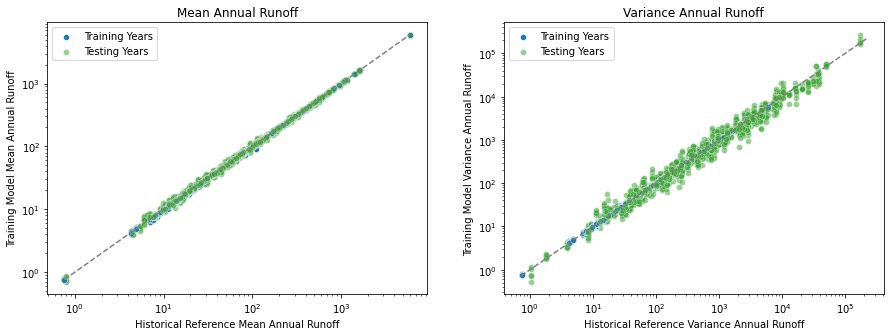

In [6]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
for w in range(5):
    sns.scatterplot(ax=ax1,x=obs_mean_train,y=model_means_train_median[w,:],color=cpal[1],label='Training Years',legend=False,alpha=1)
    sns.scatterplot(ax=ax1,x=obs_mean_test,y=model_means_test_median[w,:],color=cpal[3],label='Testing Years',legend=False,alpha=0.5)
    sns.scatterplot(ax=ax2,x=obs_mean_train,y=model_means_train_median[w,:],color=cpal[1],label='Training Years',legend=False,alpha=1)
    sns.scatterplot(ax=ax2,x=obs_var_test,y=model_vars_test_median[w,:],color=cpal[3],label='Testing Years',legend=False,alpha=0.5)
sns.lineplot(ax=ax1,x=np.linspace(np.min(obs_mean_train),np.max(obs_mean_train),100),
             y=np.linspace(np.min(obs_mean_train),np.max(obs_mean_train),100),ls='--',color='gray')
sns.lineplot(ax=ax2,x=np.linspace(np.min(obs_var_train),np.max(obs_var_train),100),
             y=np.linspace(np.min(obs_var_train),np.max(obs_var_train),100),ls='--',color='gray')
h, l = ax1.get_legend_handles_labels()
ax1.legend(h[:2],l[:2])
ax1.set_xlabel('Historical Reference Mean Annual Runoff'); ax1.set_ylabel('Training Model Mean Annual Runoff')
ax1.set_xscale('log'); ax1.set_yscale('log'); ax1.set_title('Mean Annual Runoff')
ax2.legend(h[:2],l[:2])
ax2.set_xlabel('Historical Reference Variance Annual Runoff'); ax2.set_ylabel('Training Model Variance Annual Runoff')
ax2.set_xscale('log'); ax2.set_yscale('log'); ax2.set_title('Variance Annual Runoff')
plt.savefig(spath+'S2.png',dpi=300)
plt.savefig(spath+'S2.pdf')
#plt.close()

# Run full model for 1,000 stochastic ensemble members

In [7]:
m = 1000 # set number of stochastic realizations

[Q,sym,mineig_orig,mineig_new,pct_fro] = future_stoch_mvnorm(df,df_fut,m) #simulate stochastic realizations
Q[Q<0] = 0 # make sure there are no negative runoff values - set minimum to be zero for both historical and future

basin_nms = df.basin_name.unique() # get basin names
nbasins = len(basin_nms) # get # of basins
nyears = len(df['year'].unique()[:]) # get # of years

# get historical values
Q_hist = Q[:nyears,:,:]
q_ref = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_obs'].apply(lambda x:x).to_numpy(),
                       (nyears,nbasins),order='F')
q_det = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_det'].apply(lambda x:x).to_numpy(),
                   (nyears,nbasins),order='F')

# get future values
Q_fut = Q[nyears:,:,:]
nfyears = len(df_fut.year.unique()) #length 
df_fut['q_fut'] = df_fut['q_fut'].astype(float)
q_fut = np.reshape(df_fut.groupby(['basin_id'],group_keys=False)['q_fut'].apply(lambda x:x).to_numpy(),
                       (nfyears,nbasins),order='F')


# Figure S3: How does model do at preserving cross correlation structure of observed runoff?

In [8]:
# determine the cross-correlation between every two basins for the different flow datasets
basin_ids = df.basin_id.unique()[:]
basin_names = df.basin_name.unique()[:]
nyears = len(df.year.unique())
nbasins = len(df.basin_id.unique())

#for observed historical (watergap2)
q_obs = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_obs'].apply(lambda x:x).to_numpy(),
                   (nyears,nbasins),order='F') #matrix of runoff values
corr_vals_obs = np.corrcoef(q_obs.T) #cross correlation coefficients

#for simulated historical (xanthos)
q_det = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_det'].apply(lambda x:x).to_numpy(),
                   (nyears,nbasins),order='F') #matrix of runoff values
corr_vals_det = np.corrcoef(q_det.T) #cross correlation coefficients

#correlation structure of the errors
q_diff = q_obs - q_det #matrix of differences in runoff
corr_vals_err = np.corrcoef(q_diff.T) #cross correlation coefficients of differences

#calculate cross-correlation for stochastic ensemble between all basins
corr_vals_stoch = corr_vals_stoch(Q_hist,m,nbasins)
corr_vals_stoch_med = np.mean(corr_vals_stoch,axis=2)

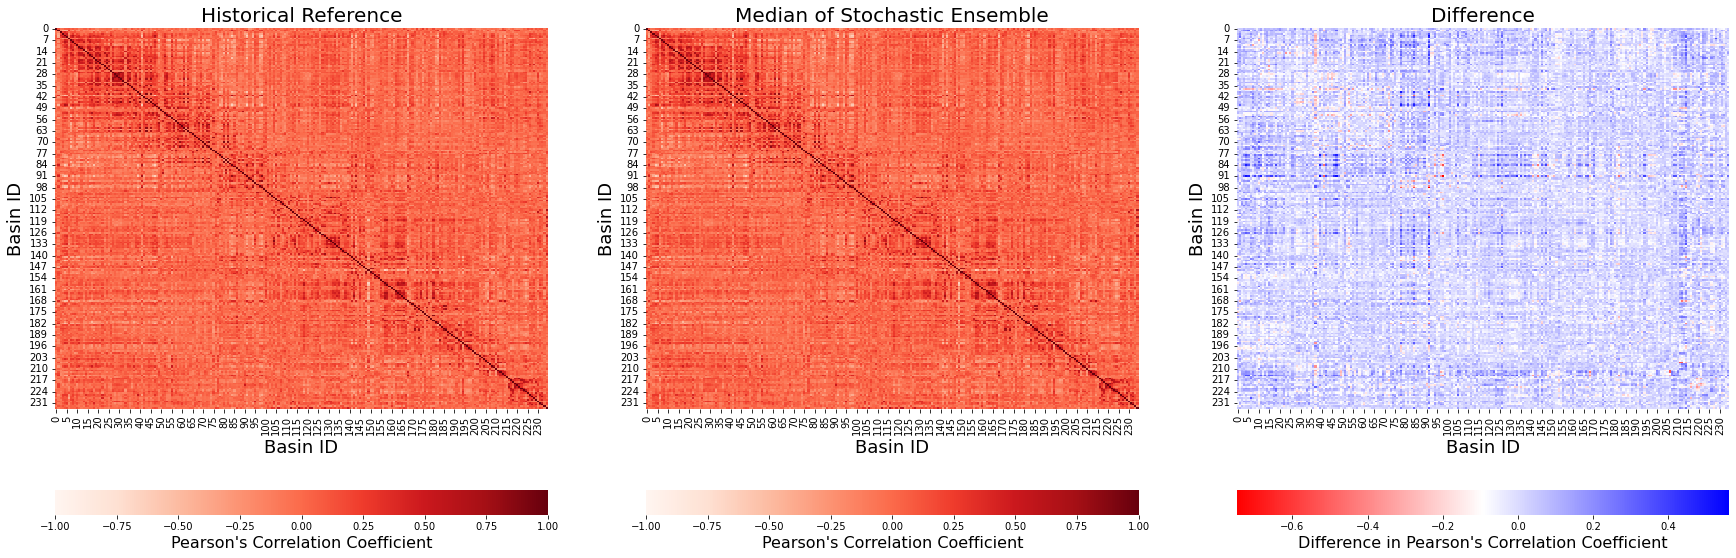

In [9]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(30,10))

#observed
sns.heatmap(data=corr_vals_obs,vmin=-1,vmax=1,cmap='Reds',ax=ax1,cbar_kws={'label':'Pearson\'s Correlation Coefficient',
                                                                          'orientation':'horizontal'})
ax1.set_xlabel('Basin ID',fontsize=18)
ax1.set_ylabel('Basin ID',fontsize=18)
ax1.set_title('Historical Reference',fontsize=20)
ax1.figure.axes[-1].xaxis.label.set_size(16)

#stochastic median
sns.heatmap(data=corr_vals_obs,cmap='Reds',vmin=-1,vmax=1,ax=ax2,cbar_kws={'label':'Pearson\'s Correlation Coefficient',
                                                                          'orientation':'horizontal'})
ax2.set_xlabel('Basin ID',fontsize=18)
ax2.set_ylabel('Basin ID',fontsize=18)
ax2.set_title('Median of Stochastic Ensemble',fontsize=20)
ax2.figure.axes[-1].xaxis.label.set_size(16)

#difference
corr_vals_diff = corr_vals_stoch_med-corr_vals_obs
sns.heatmap(data=corr_vals_diff,cmap='bwr_r',
            ax=ax3,cbar_kws={'label':'Difference in Pearson\'s Correlation Coefficient','orientation':'horizontal'})
ax3.set_xlabel('Basin ID',fontsize=18)
ax3.set_ylabel('Basin ID',fontsize=18)
ax3.set_title('Difference',fontsize=20)
ax3.figure.axes[-1].xaxis.label.set_size(16)

plt.savefig(spath+'S3_heatmaps.pdf')
plt.savefig(spath+'S3_heatmaps.png',dpi=300)
#plt.close()

In [10]:
#what % of basin-to-basin correlation pairings are less than 10%?
corr_vals_perr = 100*((corr_vals_stoch_med-corr_vals_obs)/corr_vals_obs)
ntril = np.tril_indices(nbasins)
cvd_perr = corr_vals_perr[ntril]
100*len(cvd_perr[cvd_perr<10])/len(cvd_perr)

68.86043995672557

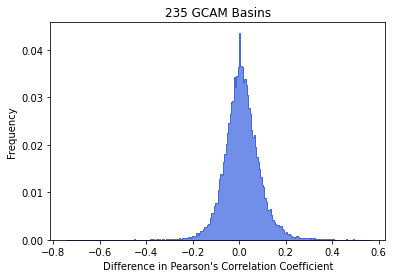

In [11]:
ntril = np.tril_indices(nbasins)
cvd = corr_vals_diff[ntril]
sns.histplot(cvd,stat='probability',color='royalblue',element='step')
plt.xlabel('Difference in Pearson\'s Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('235 GCAM Basins')
plt.savefig(spath+'S3_hist.png',dpi=300)
plt.savefig(spath+'S3_hist.pdf')
#plt.close()

# Figure S4: selecting 100 scenarios based off of cumalative runoff in Indus

We have reproduced the code used to generate Figure 5 below, however the dataset of 10,000 ensemble members is quite large (>3 GB) so it is not included. Please contact abigial.birnbaum@tufts.edu with any questions or for access to this raw data.

In [12]:
# #let us look at cumulative runoff in 2100 (from 2070 to 2100)
# bsid_indus = 89
# Qf_indus = Q[nyears+nfyears-30:,bsid_indus-1,:]

# #calculate cumulative
# Qf_indus_sum = np.cumsum(Qf_indus,axis=0)
# Qf_indus_sum = Qf_indus_sum[-1,:]
# Qf_indus_sum = pd.DataFrame(Qf_indus_sum,columns=['val'])
# Qf_indus_sum = Qf_indus_sum.sort_values(by='val',ascending=True)
# Qf_indus_sum = Qf_indus_sum.reset_index()
# Qf_indus_sum['val_rank'] = Qf_indus_sum.index + 1 
# Qf_indus_sum['prob'] = Qf_indus_sum['val_rank']/len(Qf_indus_sum)

# #pick evenly distributed 100 scenarios
# Qf_random = Qf_indus_sum.iloc[np.linspace(0,9999,100).astype(int)]
# other_ind = Qf_random['index'].to_numpy()

# #Figure 5a
# sns.scatterplot(data=Qf_indus_sum,x='index',y='val',color=cpal[0])
# sns.scatterplot(data=Qf_random,x='index',y='val',color=cpal[1],label='100 Selected')
# plt.xlabel('Index')
# plt.ylabel('Cumulative Runoff 2070-2100')
# plt.title('Indus')
# plt.xlabel('')
# frame=plt.gca()
# frame.axes.get_xaxis().set_visible(False)
# plt.show()

In [13]:
# #code used to save CSVs of 100 scenarios from stochastic model
# msave = 100
# id_list = df['basin_id'].unique()[:].astype(int)
# name_list = df['basin_name'].unique()[:].astype(str)
# fpath = '/cluster/tufts/lamontagnelab/abirnb01/GCIMS/Abby_paper/gswp3w5e5data_19012019/'
# spath = '/cluster/tufts/lamontagnelab/abirnb01/GCIMS/Abby_paper/stochastic_runoff_csv_hv/'
# generate_xml(q_det,Q_fut,msave,id_list,name_list,fpath,spath)

Figure 5b demonstrates the backwards rolling mean used to input into GCAM

In [14]:
nyears = len(df.year.unique())
nbasins = len(df.basin_name.unique())
q_det = np.reshape(df.groupby(['basin_id'],group_keys=False)['q_det'].apply(lambda x:x).to_numpy(),
                   (nyears,nbasins),order='F')
#create future annual
nfyears = len(df_fut.year.unique())
id_list = df['basin_id'].unique()[:].astype(int)
name_list = df['basin_name'].unique()[:].astype(str)

#get every 5 years...
Q_mod = np.concatenate((q_det[nyears-5:,:],q_fut),axis=0)
Q_ma = pd.DataFrame(Q_mod).rolling(5).mean() #calculate backwards rolling mean
Q_ma = Q_ma.iloc[5:,:] #start with value in 2020
Q_ma = Q_ma.to_numpy()
Q_scen = pd.DataFrame(Q_ma[::5,:]).T #start with value in 2020
conv_Q = pd.DataFrame() #empty dataframe
conv_Q['basin_id'] = id_list
conv_Q['basin_name'] = name_list
conv_Q = pd.concat([conv_Q,Q_scen],axis=1) #add to larger matrix

# create list of column names for the years
yrs = np.linspace(2020,2100,17).astype(int)
col_names = conv_Q.columns[2:].to_numpy()
col_dict = dict(zip(col_names,yrs))
conv_Q = conv_Q.rename(columns=col_dict) #rename columns
conv_Q = conv_Q.melt(id_vars=['basin_id','basin_name'],var_name='year',
                    value_name = 'maxSubResource') # restructure dataframe to appropriate format for xml

#load in mapping CSVs - this is so we are assigning the correct region
basinid_gluname = pd.read_csv(fpath+'Shapefiles_for_mapping/basin_to_country_mapping.csv')
gluname_region = pd.read_csv(fpath+'Shapefiles_for_mapping/basin_to_region_mapping.csv')

#make dictionaries
bname_dict = dict(zip(basinid_gluname.GCAM_basin_ID,basinid_gluname.GLU_name))
basreg_dict = dict(zip(gluname_region.gcam_basin_name, gluname_region.region))

conv_Q['renewresource'] = conv_Q['basin_id'].map(bname_dict)
conv_Q['region'] = conv_Q['renewresource'].map(basreg_dict)
conv_Q['sub.renewable.resource'] = 'runoff'
conv_Q['renewresource'] = conv_Q['renewresource'] + '_water withdrawals'
conv_Q = conv_Q[~conv_Q.region.isna()]
conv_Q = conv_Q.sort_values(by=['basin_id','year'])
conv_Q = conv_Q.filter(['region','renewresource','sub.renewable.resource','year','maxSubResource'])

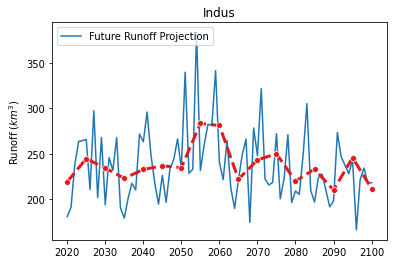

In [15]:
#pick a basin
bsid = 89
df_basin_fut = df_fut[df_fut.basin_id == bsid]
sns.lineplot(x=df_basin_fut.year,y=df_basin_fut.q_fut,color=cpal[1],label='Future Runoff Projection')
sns.lineplot(x=np.linspace(2020,2100,17),y=Q_scen.iloc[bsid-1,:],color=cpal[5],ls='--',lw=3)
sns.lineplot(x=np.linspace(2020,2100,17),y=Q_scen.iloc[bsid-1,:],marker='o',color=cpal[5],ls='')
plt.title(df_basin_fut.basin_name.iloc[0])
plt.xlabel('')
plt.ylabel('Runoff ($km^3$)')
plt.legend(loc='upper left')
plt.savefig(spath+'S4_ts.png',dpi=300)
plt.savefig(spath+'S4_ts.pdf')
#plt.close()

# Figure S5: water withdrawals in Indus basin 2020-2100

In [16]:
#load in data
#total water withdrawals
ww = pd.read_pickle(fpath+'GCAM_queries/ww'); ww = ww[(ww.year>=2015)];
#groundwater withdrawals
ww_gw = pd.read_pickle(fpath+'GCAM_queries/ww_gw')
#surface water withdrawals
ww_sw = pd.read_pickle(fpath+'GCAM_queries/ww_sw')
ww_indus = ww[(ww.year>=2015) & (ww.basin=='IndusR')] #total water withdrawals
ww_sw_indus = ww_sw[(ww_sw.year>=2015) & (ww_sw.basin=='IndusR')] #surface water withdrawals
years = ww_indus.year.unique()

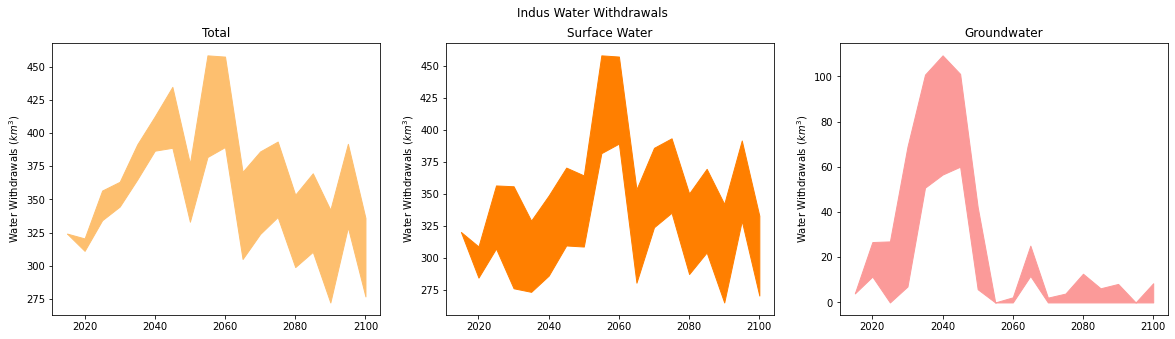

In [17]:
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(20,5))

#total water withdrawals use in the indus
ww_indus_min = ww_indus.groupby(['year'])['value'].min().reset_index().sort_values(by='year',ascending=True)
ww_indus_max = ww_indus.groupby(['year'])['value'].max().reset_index().sort_values(by='year',ascending=True)
ww_indus_min = ww_indus_min['value'].to_numpy()
ww_indus_max = ww_indus_max['value'].to_numpy()

ax1.fill_between(years,ww_indus_min,ww_indus_max,color=cpal[6])
ax1.set_ylabel('Water Withdrawals ($km^3$)')
ax1.set_title('Total')

#surface water use in the indus
ww_sw_indus_min = ww_sw_indus.groupby(['year'])['value'].min().reset_index().sort_values(by='year',ascending=True)
ww_sw_indus_max = ww_sw_indus.groupby(['year'])['value'].max().reset_index().sort_values(by='year',ascending=True)
ww_sw_indus_min = ww_sw_indus_min['value'].to_numpy()
ww_sw_indus_max = ww_sw_indus_max['value'].to_numpy()

ax2.fill_between(years,ww_sw_indus_min,ww_sw_indus_max,color=cpal[7])
ax2.set_ylabel('Water Withdrawals ($km^3$)')
ax2.set_title('Surface Water')

#groundwater use in the indus
ww_gw_indus = ww_gw[(ww_gw.year>=2015) & (ww_gw.basin=='IndusR')] #surface water withdrawals
ww_gw_indus_min = ww_gw_indus.groupby(['year'])['value'].min().reset_index().sort_values(by='year',ascending=True)
ww_gw_indus_max = ww_gw_indus.groupby(['year'])['value'].max().reset_index().sort_values(by='year',ascending=True)
ww_gw_indus_min = ww_gw_indus_min['value'].to_numpy()
ww_gw_indus_max = ww_gw_indus_max['value'].to_numpy()

ax3.fill_between(years,ww_gw_indus_min,ww_gw_indus_max,color=cpal[4])
ax3.set_ylabel('Water Withdrawals ($km^3$)')
ax3.set_title('Groundwater')

plt.suptitle('Indus Water Withdrawals')
plt.savefig(spath+'S5.png',dpi=300)
plt.savefig(spath+'S5.pdf')
#plt.close()